### Use the LLH Client & Service to produce FreeDOM LLH scans

Intended to demonstrate the LLH service functionality

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import json
import math
from matplotlib import pyplot as plt
from freedom.llh_service.llh_service import LLHService
from freedom.llh_service.llh_client import LLHClient
from multiprocessing import Process

In [2]:
with open('../../freedom/resources/test_data/test_events.pkl', 'rb') as f:
    event = pickle.load(f)[100]

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.27499998
 0.         0.         0.         0.         0.         0.
 0.         0.         0.77499998 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 2.77499999 2.05000007 0.         0.         0.         2.97500002
 0.27500001 0.        ]


### llh service configuration:

In [3]:
service_conf = {
        "req_addr": "tcp://127.0.0.1:12345",
        "ctrl_addr": "tcp://127.0.0.1:12346",
        "poll_timeout": 1,
        "flush_period": 1,
        "n_hypo_params": 8,
        "n_hit_features": 9,
        "n_evt_features": 86,
        "batch_size" : {
          "n_hypos": 250,
          "n_observations": 4000 
        },
        "send_hwm": 10000,
        "recv_hwm": 10000,
        "use_freeDOM_model": True,
        "hitnet_file": "HitNet_logE18_May_2020-21h02/epoch_32_model.hdf5",
        "superstringnet_file": "SuperStringNet_06_Jul_2020/superstring_2**7_40epoch.h5"
}
event['total_charge']


array([10.12499905, 11.        ])

In [4]:
# start the service in a separate process
def start_service(params):
    with LLHService(**params) as serv:
        print('starting work loop...')
        serv.start_work_loop()
        
    print('done')

proc = Process(target=start_service, args=(service_conf,))
proc.start()

starting work loop...
Received die command... flushing and exiting
cleaning up
done


### Construct the client
The client loads its configuration directly from the service. Client construction will block until a connection to the service is established or "conf_timeout" milliseconds have elapsed.

In this case, it will block until the service has finished initializing.

In [5]:
%%time
client = LLHClient(
                    ctrl_addr=service_conf["ctrl_addr"],
                    conf_timeout=60000
                  )

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 727 ms


In [6]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

# utility function to map out a 2d NLL slice
def map_2d(inds, steps, event, base_params=event['params']):
    mg = np.meshgrid(*steps)
    
    n_hypotheses = mg[0].size
    
    # param table is a table of hypotheses to evaluate
    # each row contains a value for each of the 8 hypothesis parameters
    param_table = np.repeat(base_params[np.newaxis, :], n_hypotheses, axis=0)

    # load hypotheses to evaluate into the param table
    for ind, coord in zip(inds, mg):
        param_table[:, ind] = coord.flat
        
    # client.eval_llh is a synchronous (blocking) LLH evaluation
    # asynchronous requests are also supported
    return client.eval_llh(event['hits'], event['strings'][:,3], param_table).reshape([step.size for step in steps[::-1]])

def plot_2d(inds, steps, true_params, ax):
    llh_map = map_2d(inds, steps, event)

    delta = llh_map - llh_map.min()
    
    im = ax.pcolormesh(*steps, delta, cmap='Spectral', 
                       rasterized=True, linewidth=0)    
    colorbar(im)
    
    mle_y, mle_x = np.unravel_index(np.argmin(llh_map), llh_map.shape)
    
    # place crosshair at true parameters
    ax.axvline(true_params[0])
    ax.axhline(true_params[1])
    
    # white star at MLE point in the 2d scan
    ax.plot(*[[step[i]] for step, i in zip(steps, (mle_x, mle_y))], 'w*')

In [7]:
true_params = event['params']

par_names = ['x', 'y', 'z', 'time',
             'azimuth', 'zenith', 
             'cascade energy', 'track energy']

par_pairs = [(0, 1), (0, 2), (1, 2), (3, 2),
             (4, 5), (4, 2), (4, 0), (6, 7)
            ]

gridsize=100
spacings = [np.linspace(true_params[0]-50, true_params[0]+50, 100),
            np.linspace(true_params[1]-50, true_params[1]+50, 100),
            np.linspace(true_params[2]-50, true_params[2]+50, 100),
            np.linspace(true_params[3]-300, true_params[3]+300, 100),
            np.linspace(0, 2*math.pi, 100),
            np.linspace(0, math.pi, 100),
            np.logspace(-1, 2, 100),
            np.logspace(-1, 2, 100)
           ]

CPU times: user 1.67 s, sys: 76 ms, total: 1.75 s
Wall time: 5.13 s


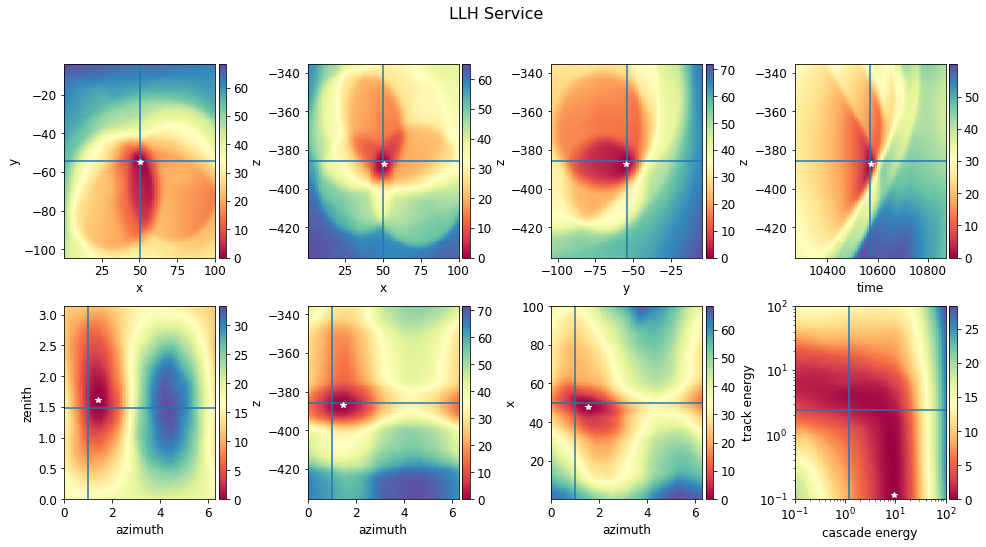

In [8]:
%%time
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.25)

axiter = axes.flat
for i, ax in enumerate(axiter):
    ind0, ind1 = par_pairs[i]
    grid_spacing = (spacings[ind0], spacings[ind1])
    plot_2d((ind0, ind1), grid_spacing, (true_params[ind0], true_params[ind1]), ax)
    ax.set_xlabel(par_names[ind0], fontsize=12)
    ax.set_ylabel(par_names[ind1], fontsize=12)
    ax.tick_params(labelsize=12)
    
    if par_names[ind0].endswith('energy'):
        ax.set_xscale('log')
    if par_names[ind1].endswith('energy'):
        ax.set_yscale('log')
    
fig.suptitle('LLH Service', fontsize=16)
fig.savefig('llh_service_maps.pdf', bbox='tight')

In [9]:
# time it
t = %timeit -o output = map_2d((0,1), (spacings[0], spacings[1]), event)

433 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
print(f'time per eval is {t.average/gridsize**2*1e6:.2f} usec')

time per eval is 43.29 usec


In [11]:
# kill the service
import zmq
ctrl_sock = zmq.Context.instance().socket(zmq.REQ)
ctrl_sock.connect(service_conf["ctrl_addr"])
ctrl_sock.send_string("die")
proc.join()